## Обучаем классификатор

In [2]:
from Bio import SeqIO

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from tqdm.auto import tqdm

%matplotlib inline

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import Sampler, BatchSampler
from torch.nn.modules.loss import MSELoss
from sklearn.model_selection import train_test_split

In [4]:
label_dict = {
    "a": [0, 0, 0, 1],
    "t": [0, 0, 1, 0],
    "g": [0, 1, 0, 0], 
    "c": [1, 0, 0, 0]
}

def nuc_to_int(sequence):
    #return np.asarray([label_dict[nuc] for nuc in sequence]).transpose(1,0)
    return [label_dict[nuc] for nuc in sequence]
        

def get_dnas(file):
    j = 0
    for i, record in enumerate(tqdm(SeqIO.parse(file, "fasta"))):
        seq = record.seq.lower()
        if "n" in seq:
            continue
        j += 1
        if j > 30000:
            return
        yield nuc_to_int(seq)

In [5]:
from torch.utils.data.dataset import Dataset

class G4Dataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.FloatTensor(data)
        self.labels = torch.FloatTensor(labels)
        
    def __getitem__(self, index):
        return (self.data[index], self.labels[index])

    def __len__(self):
        return self.data.shape[0]

In [6]:
from sklearn.model_selection import train_test_split
from itertools import chain

from torch.utils.data.dataset import random_split

TEST_SIZE = 0.2
BATCH_SIZE = 128

def make_dataset():
    #data_plus = np.asarray(list(get_dnas('plus_class_only_plus2.fa')), dtype=np.float32)
#     dt = list(get_dnas('random_final.fasta'))
#     print(len(dt[1]))
#     for i, x in enumerate(dt):
#         print(i, np.asarray(x, dtype=np.float32))
    data_random = np.asarray(list(get_dnas('random_final.fasta')), dtype=np.float32)
    data_plus = np.asarray(list(get_dnas('plus_500.fasta')), dtype=np.float32)
    #data_minus = np.asarray(list(get_dnas('mn_500.fasta')), dtype=np.float32)
    
    #data_random = np.asarray(list(get_dnas('minus_class.fa')), dtype=np.float32)

    #length = len(data_random)# + len(data_minus)
    length = len(data_plus)
    #length = len(data_minus)
    data = np.concatenate((data_plus, data_random[:length]))
    #data = np.concatenate((data_minus, data_random[:length]))
    #print(data_plus.shape, data_minus.shape, data_random.shape, len(np.ones(length)), len(np.zeros(length)))
    labels = np.concatenate((np.ones(length), np.zeros(length)))#, dtype=torch.float, device=cuda)
    return data, data_plus, data_random, labels
  
data, data_plus, data_random, labels = make_dataset()

In [7]:
train_len = int(len(data) * 0.8)
test_len = len(data) - train_len
print(len(data), len(labels), train_len, test_len)
#X_train, X_test, y_train, y_test = random_split((data, labels), [train_len, test_len])
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

60000 60000 48000 12000


In [8]:
g4_train = G4Dataset(X_train, y_train)
g4_test = G4Dataset(X_test, y_test)

In [9]:
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(dataset=g4_train, 
                                           batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(dataset=g4_test, 
                                           batch_size=BATCH_SIZE)

In [10]:
class CNNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(4, 16, 5),
            nn.MaxPool1d(5),
            nn.ReLU(),
            nn.Conv1d(16, 16, 5),
            nn.MaxPool1d(5),
            nn.ReLU(),            
        )
        self.lin = nn.Sequential(
            nn.Linear(304, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.cnn(x).view(x.shape[0], -1)
        output = self.lin(output)
        return output

In [41]:
from tqdm.auto import tqdm
from IPython.display import clear_output

def train_epoch(model, optimizer):
    loss_log = []
    model.train()
    for batch_num, (data, target) in tqdm(list(enumerate(train_loader))):
        data = data.transpose(1, 2)
        optimizer.zero_grad()
        output = model(data)  
        loss = F.binary_cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        print(loss)
        loss_log.append(loss)
    return loss_log   

def test(model):
    loss_log = []
    model.eval()
    for batch_num, (data, target) in tqdm(list(enumerate(test_loader))): 
        data = data.transpose(1, 2)
        output = model(data)
        loss = F.binary_cross_entropy(output, target)
        loss = loss.item()
        loss_log.append(loss)
    return loss_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)    
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs):
    train_log = []
    val_log = []

    for epoch in range(n_epochs):
        print("Epoch {0} of {1}".format(epoch, n_epochs))
        train_loss = train_epoch(model, opt)
        val_loss = test(model)
        train_log.extend(train_loss)
        steps = y_train.shape[0] / BATCH_SIZE
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        clear_output()
        plot_history(train_log, val_log)

In [49]:
# model = CNNNet()
model = CNNNet()

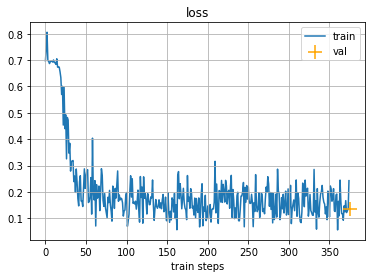

In [50]:
opt = torch.optim.Adam(model.parameters(), lr=0.02)
train(model, opt, 1)

In [51]:
from sklearn.metrics import roc_auc_score

data = torch.tensor(X_test, dtype=torch.float).transpose(1, 2)
model.eval()
with torch.no_grad():
    pred = model(data).numpy()

print(roc_auc_score(y_test, pred))

0.9780387677509931


In [52]:
y_pred = pred > 0.5
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

print(f1_score(y_test, y_pred, average="macro"))
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="macro"))  

0.9612854552709477
0.9623219989033849
0.9610210337550146


In [53]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[5979,  112],
       [ 352, 5557]], dtype=int64)

Text(0.5, 1.0, 'Confusion Matrix')

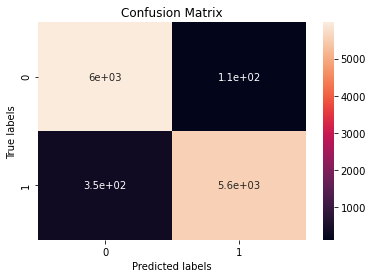

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [55]:
torch.save(model, 'model')

c:\users\burda\appdata\local\programs\python\python38\lib\site-packages\torch\serialization.py:401: UserWarning: Couldn't retrieve source code for container of type CNNNet. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


## Генерируем новые квадруплексы

In [11]:
from torch.utils.data.dataset import Dataset

label_dict = {
    "a": [0, 0, 0, 1],
    "t": [0, 0, 1, 0],
    "g": [0, 1, 0, 0], 
    "c": [1, 0, 0, 0]
}

def nuc_to_int(sequence):
    return np.asarray([label_dict[nuc] for nuc in sequence]).transpose(1,0)
        

def get_dnas(file):
    j = 0
    for i, record in enumerate(tqdm(SeqIO.parse(file, "fasta"))):
        seq = record.seq.lower()
        if "n" in seq:
            continue
        j += 1
        if j > 30000:
            return
        yield nuc_to_int(seq)
        
class G4Dataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.int64)
        
    def __getitem__(self, index):
        return (self.data[index], self.labels[index])

    def __len__(self):
        return self.data.shape[0]
    
from sklearn.model_selection import train_test_split
from itertools import chain

from torch.utils.data.dataset import random_split


def make_dataset():
#     data_plus = np.asarray(list(get_dnas('plus_class_only_plus2.fa')), dtype=np.float32)
#     #labels = np.concatenate((np.ones(length), np.zeros(length)))#, dtype=torch.float, device=cuda)
#     labels = np.ones(data_plus.shape[0])
#     #data_random = np.asarray(list(get_dnas('minus_class.fa')), dtype=np.float32)
    
    data_plus = np.asarray(list(get_dnas('plus_500.fasta')), dtype=np.float32)
    #data_minus = np.asarray(list(get_dnas('mn_500.fasta')), dtype=np.float32)

    length = len(data_plus) #+ len(data_minus)
    data = data_plus# np.concatenate((data_plus, data_minus))
    labels = np.ones(data.shape[0])
    #labels = np.concatenate((np.ones(length), np.zeros(length)))#, dtype=torch.float, device=cuda)
    return data, labels
  
data, labels = make_dataset()

In [12]:
train_len = int(len(data) * 0.8)
test_len = len(data) - train_len
print(len(data), len(labels), train_len, test_len)
#X_train, X_test, y_train, y_test = random_split((data, labels), [train_len, test_len])
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

g4_train = G4Dataset(X_train, y_train)
g4_test = G4Dataset(X_test, y_test)

30000 30000 24000 6000


In [13]:
class View(nn.Module):
    def __init__(self, shape):
        super(View, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(-1, *self.shape)

In [14]:
# https://github.com/caogang/wgan-gp/blob/master/gan_mnist.py

def calc_gradient_penalty_classic(critic:torch.nn.Module,
                                  real_data:torch.Tensor,
                                  fake_data:torch.Tensor):
    """
    Computes Gradient Penalty in random interpolates, in its classic form:
    (|∇(D(x)|^2 - 1)^2, x is interpolated between a real and a generated sample
    Args:
      critic: a torch model which gradient needs to be penalised
      real_data[batch_size, n_features]: a sample of real data
      fake_data[batch_size, n_features]: a sample of fake data
    Returns:
      torch.Tensor, scalar, gradient penalty evalute
    """

    alpha = torch.rand(real_data.shape[0], 500, 4).transpose(2, 1).cuda()
    if real_data.shape != fake_data.shape:
        return 0
        print(alpha.shape, real_data.shape, fake_data.shape, real_data.shape[1], fake_data.transpose(0,1))
    #alpha = alpha.expand(-1, -1, 4).cuda().transpose(2, 1)


    interpolates = (alpha * real_data + ((1 - alpha) * fake_data))
    interpolates = torch.autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = critic(interpolates)

    gradients = torch.autograd.grad(
        outputs=disc_interpolates, inputs=interpolates,
        grad_outputs=torch.ones(disc_interpolates.size(), device="cuda"),
        create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [15]:
BATCH_SIZE = 128

def sample_real_data(batch_size):
    while True:
        dataloader = torch.utils.data.DataLoader(dataset=g4_train, 
                                           batch_size=BATCH_SIZE)
        for batch in dataloader:
            yield batch

In [16]:
# Эта функция семплит данные из вашего генератора
# Принимает на вход x (condition) 
# Возвращает concat(gen_y, x)

LATENT_DIM = 40 # Размерность "шума"

def sample_gen_data(gen, x):
    noise = torch.randn(BATCH_SIZE, LATENT_DIM, device='cuda')
    return gen(noise)

In [636]:
LAMBDA = 1. # for gradient-penalty
def train_disc(infinite_data, gen, disc, disc_opt, gan_type):
    real_data = next(infinite_data)[0].to("cuda")
    gen_data = sample_gen_data(gen, real_data)
    
    if gan_type == "JS":
        disc_loss = -disc(real_data).log().mean() - (1 - disc(gen_data)).log().mean()
    elif gan_type == "WGAN":
        disc_loss = -disc(real_data).mean() + disc(gen_data).mean() 
    elif gan_type == "LSGAN":
        disc_loss = ((disc(real_data)) ** 2).mean() + ((1 - disc(gen_data)) ** 2).mean()
    elif gan_type == "WGAN-GP":
        #print(calc_gradient_penalty_classic(disc, real_data, gen_data))
        disc_loss = -disc(real_data).mean() + disc(gen_data).mean() + LAMBDA * calc_gradient_penalty_classic(disc, real_data, gen_data)
    else:
        raise ValueError("Unknown GAN type. Valid ones are: JS, WGAN-GP, WGAN, LSGAN")
    
    disc_opt.zero_grad()
    disc_loss.backward()
    disc_opt.step()
    if gan_type == "WGAN":
        for p in disc.parameters():
            p.data.clamp_(-1, 1)
    return disc_loss

In [637]:
def train_gen(infinite_data, gen, disc, gen_opt, gan_type):
    """Trains generator for one step"""
    real_data_x = next(infinite_data)[0].to("cuda")
    
    gen_data = sample_gen_data(gen, real_data_x)
    
    if gan_type == "JS":
        gen_loss = (1 - disc(gen_data)).log().mean()
    elif gan_type == "WGAN":
        gen_loss = -disc(gen_data).mean()
    elif gan_type == "LSGAN":
        gen_loss = ((disc(gen_data)) ** 2).mean()
    elif gan_type == "WGAN-GP":
        gen_loss = -disc(gen_data).mean()
    else:
        raise ValueError("Unknown GAN type. Valid ones are: JS, WGAN-GP, WGAN, LSGAN")
        
    gen_opt.zero_grad()
    gen_loss.backward()
    gen_opt.step()
    return gen_loss

In [638]:
import matplotlib.pyplot as plt

In [798]:
from IPython.display import clear_output
from torch.optim.lr_scheduler import StepLR
DISCRIMINATOR_ITERATIONS_PER_GENEREATOR = 5
DATA_HIST_RANGE=[-5, 5]
VALIDATION_INTERVAL = 256
HIST_BINS=100
NUM_CHANNELS = 64
NUM_CHANNELS_D = 16

class ResBlock(nn.Module):
    def __init__(self, num_channels):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv1d(num_channels, num_channels, 5, padding=2)
        self.conv2 = nn.Conv1d(num_channels, num_channels, 5, padding=2)
        self.norm = nn.BatchNorm1d(num_channels)
        self.norm2 = nn.BatchNorm1d(num_channels)

    def forward(self, x):
        return self.norm2(self.conv2(self.relu(self.norm(self.conv(self.relu(x)))))) * 0.3 + x

def do(gan_type, n_iter=100000):
    torch.cuda.empty_cache()
    gen = nn.Sequential(
        # Gen2
        nn.Linear(LATENT_DIM, 500 * NUM_CHANNELS),
        View((NUM_CHANNELS, 500)),
        ResBlock(NUM_CHANNELS),
        ResBlock(NUM_CHANNELS),
        ResBlock(NUM_CHANNELS),
        ResBlock(NUM_CHANNELS),
        ResBlock(NUM_CHANNELS),
        nn.Conv1d(NUM_CHANNELS, 4, 5, padding=2),
        nn.Softmax(dim=1)
        # Gen1
#         nn.Linear(LATENT_DIM, 288),
#         View((NUM_CHANNELS, 18)), # Unflatten
#         nn.BatchNorm1d(NUM_CHANNELS),
#         nn.ReLU(),
#         nn.ConvTranspose1d(in_channels=NUM_CHANNELS, out_channels=NUM_CHANNELS, kernel_size=3, stride=3, output_padding=1),
#         nn.BatchNorm1d(NUM_CHANNELS),
#         nn.ReLU(),
#         nn.ConvTranspose1d(in_channels=NUM_CHANNELS, out_channels=NUM_CHANNELS, kernel_size=3, stride=3, output_padding=1),
#         nn.BatchNorm1d(NUM_CHANNELS),
#         nn.ReLU(),
#         nn.ConvTranspose1d(in_channels=NUM_CHANNELS, out_channels=4, kernel_size=3, stride=3, output_padding=2),
#         nn.Softmax(dim=1)
    ).cuda()
    gen_opt = torch.optim.RMSprop(gen.parameters(), lr=0.00005)
    gen_scheduler = StepLR(gen_opt, 100, gamma=0.9)

#     assert gen[0].in_features == LATENT_DIM + len(X_COLUMNS)
#     assert gen[-1].out_features == len(Y_COLUMNS)
    
    dd = [
        # Disc1
        # NUM_CHANNELS_D = 16
#         nn.Conv1d(4, NUM_CHANNELS_D, 3),
#         nn.ReLU(),
#         nn.BatchNorm1d(NUM_CHANNELS_D),
#         nn.MaxPool1d(3),
#         nn.Conv1d(NUM_CHANNELS_D, NUM_CHANNELS_D, 3),
#         nn.ReLU(),
#         nn.BatchNorm1d(NUM_CHANNELS_D),
#         nn.MaxPool1d(3),
#         nn.Conv1d(NUM_CHANNELS_D, NUM_CHANNELS_D, 3),
#         nn.ReLU(),
#         nn.BatchNorm1d(NUM_CHANNELS_D),
#         nn.MaxPool1d(3),
#         nn.Flatten(),
#         nn.Linear(NUM_CHANNELS_D * 17, 128),
#         nn.ReLU(),
#         nn.Linear(128, 1),
        #Disc2
        nn.Conv1d(4, NUM_CHANNELS, 1),
        ResBlock(NUM_CHANNELS),
        ResBlock(NUM_CHANNELS),
        ResBlock(NUM_CHANNELS),
        ResBlock(NUM_CHANNELS),
        ResBlock(NUM_CHANNELS),
        nn.Flatten(),
        nn.Linear(NUM_CHANNELS * 500, 1),
        #Disc3
#         nn.Conv1d(4, 16, 5),
#         nn.MaxPool1d(5),
#         nn.ReLU(),
#         nn.Conv1d(16, 16, 5),
#         nn.MaxPool1d(5),
#         nn.ReLU(),            
#         nn.Flatten(),
#         nn.Linear(304, 128),
#         nn.ReLU(),
#         nn.Linear(128, 1),
    ]
    if gan_type in ['JS', 'LSGAN']:
        dd.append(nn.Sigmoid())
    disc = nn.Sequential(*dd).cuda()
    disc_opt = torch.optim.RMSprop(disc.parameters(), lr=0.00005)
    disc_scheduler = StepLR(disc_opt, 100, gamma=0.9)

    
    infinite_data = sample_real_data(BATCH_SIZE) #sample_real_data(TRAIN_BATCH_SIZE)

    #experiment = Experiment(api_key="QOGSXcTRi5kCNhAMpf1vwOKIJ",
    #                     project_name="jjj", workspace="sonchaboo")
    gen_loss = []
    disc_loss = []
    loss = []
    for i in range(n_iter):
        for _ in range(DISCRIMINATOR_ITERATIONS_PER_GENEREATOR):
            disc_loss_this_iter = train_disc(infinite_data, gen, disc, disc_opt, gan_type)

        gen_loss_this_iter = train_gen(infinite_data, gen, disc, gen_opt, gan_type)
        gen_scheduler.step()
        disc_scheduler.step()
        print(i, gen_loss_this_iter.item(), disc_loss_this_iter.item())
        
        gen_loss.append(gen_loss_this_iter)
        disc_loss.append(disc_loss_this_iter)
        
        #experiment.log_metric('loss/discriminator', disc_loss_this_iter.item(), step=i)
        #experiment.log_metric('loss/generator', gen_loss_this_iter.item(), step=i)
        
        gen_data = sample_gen_data(gen, infinite_data).cpu().detach().numpy()
        if i != 0:
            gen_proba = np.concatenate((gen_proba, gen_data))
        else:
            gen_proba = gen_data

        
    #print(disc_loss_this_iter, gen_loss_this_iter)
    fig = plt.figure(figsize=(15,8))
    plt.xlabel('n_iter')
    plt.ylabel('loss')
    #plt.title('')
    ax = fig.add_subplot()
    ax.plot(range(n_iter), gen_loss, label='loss/generator')
    ax.plot(range(n_iter), disc_loss, label='loss/discriminator')
    plt.grid(True)
    plt.legend()
    
    return np.argmax(gen_proba, axis=1)

In [799]:
n_iter = 300

In [1]:
#g4_train = add

In [625]:
add = g4_train

0 -0.1014210432767868 0.3407600522041321
1 -0.04961501434445381 0.16584829986095428
2 -0.026000089943408966 0.0812249481678009
3 -0.01983833685517311 0.06149078533053398
4 -0.014334512874484062 0.04268746078014374
5 -0.012688292190432549 0.038470558822155
6 -0.008135398849844933 0.028814082965254784
7 -0.007006497122347355 0.021660301834344864
8 -0.00737284729257226 0.016188587993383408
9 -0.005311641376465559 0.019785629585385323
10 -0.004611358977854252 0.019167788326740265
11 -0.004211930558085442 0.01262880302965641
12 -0.0037031611427664757 0.011740240268409252
13 -0.0037128792610019445 0.010643642395734787
14 -0.00308337714523077 0.00987289473414421
15 -0.002747891005128622 0.009489800781011581
16 -0.0023053872864693403 0.006713071838021278
17 -0.001999504864215851 0.007820812985301018
18 -0.002036971738561988 0.00680085364729166
19 -0.002091679722070694 0.007492127362638712
20 -0.0018866801401600242 0.005489768460392952
21 -0.0014653645921498537 0.00439429422840476
22 -0.0014203

<ipython-input-798-a1f30c067815>:136: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot()


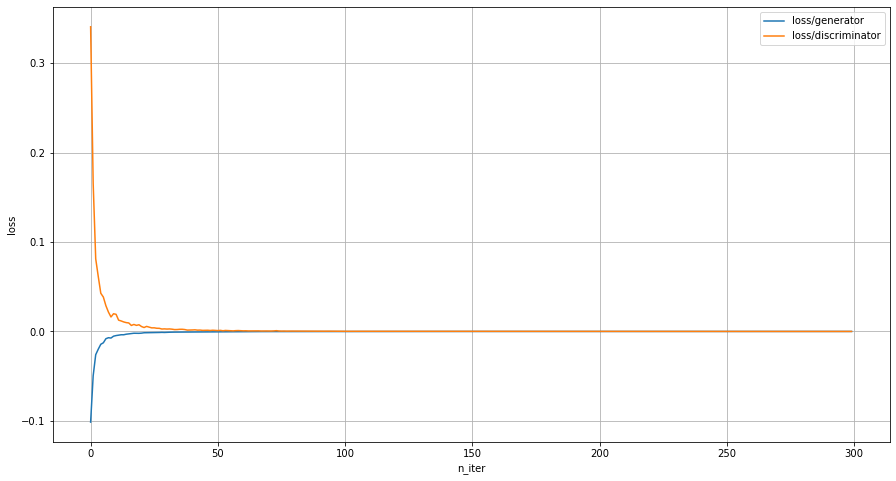

In [800]:
gd1 = do('JS', n_iter) # GAN

0 9.231498718261719 -7.949244499206543
1 17.46758460998535 -20.404203414916992
2 24.141658782958984 -36.16582489013672
3 31.24915313720703 -50.495182037353516
4 37.35674285888672 -67.0221176147461
5 42.05792236328125 -77.02033996582031
6 46.768943786621094 -95.13062286376953
7 51.145103454589844 -106.80691528320312
8 55.86878967285156 -122.30760192871094
9 60.01077651977539 -126.93440246582031
10 64.05113220214844 -141.4163360595703
11 67.38554382324219 -152.0857391357422
12 71.82090759277344 -169.93670654296875
13 75.06060028076172 -172.25814819335938
14 79.86663818359375 -175.57098388671875
15 82.49836730957031 -188.69345092773438
16 86.1959228515625 -210.11688232421875
17 89.43772888183594 -215.9735870361328
18 92.33148956298828 -207.29342651367188
19 95.98673248291016 -217.5631103515625
20 99.11587524414062 -240.85745239257812
21 101.34529876708984 -262.2385559082031
22 105.62431335449219 -256.193359375
23 108.34232330322266 -268.3816223144531
24 110.54908752441406 -285.34390258789

<ipython-input-798-a1f30c067815>:136: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot()


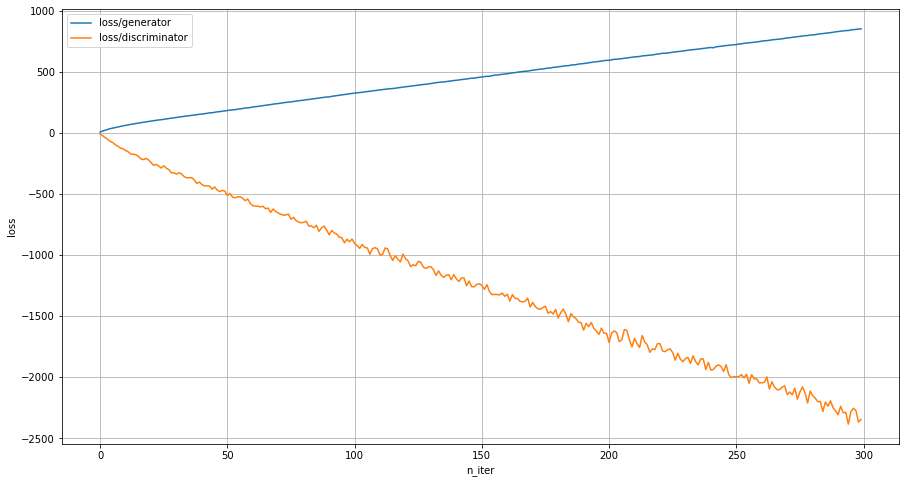

In [801]:
gd2 = do('WGAN', n_iter)

0 2.3025596141815186 -2.04590106010437
1 3.062042236328125 -3.473121166229248
2 3.440202236175537 -4.626262664794922
3 3.5197176933288574 -5.112180709838867
4 3.333784580230713 -5.503621578216553
5 3.2915143966674805 -5.831315994262695
6 2.804314613342285 -6.013942718505859
7 2.827597141265869 -5.9028425216674805
8 2.2327446937561035 -5.717630863189697
9 2.176842451095581 -5.904809951782227
10 1.9497331380844116 -5.443386077880859
11 1.5027358531951904 -5.708938121795654
12 1.3388581275939941 -5.714173793792725
13 1.2545510530471802 -4.972713470458984
14 0.6284359693527222 -4.684990406036377
15 1.1922051906585693 -4.70284366607666
16 0.8213933706283569 -4.991001605987549
17 0.7365761995315552 -4.474359512329102
18 0.8618252277374268 -3.7319087982177734
19 0.4979652464389801 -3.5318241119384766
20 0.6353251934051514 -4.358470916748047
21 1.079872727394104 -4.405432224273682
22 0.8001265525817871 -3.6225945949554443
23 0.7753000259399414 -4.284088611602783
24 1.2441365718841553 -3.913846

<ipython-input-798-a1f30c067815>:136: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot()


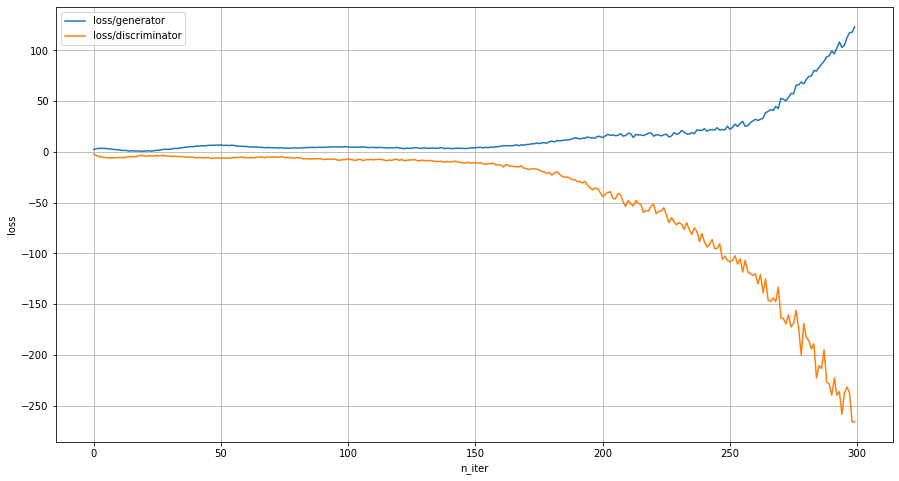

In [803]:
gd3 = do('WGAN-GP', n_iter)

0 0.9400794506072998 0.12244667112827301
1 0.8626406192779541 0.02007182687520981
2 0.8765233755111694 0.013100510463118553
3 0.8982840776443481 0.010258586145937443
4 0.9060393571853638 0.008209442719817162
5 0.9084168672561646 0.006072295363992453
6 0.9298786520957947 0.00544950645416975
7 0.9350593090057373 0.004332102835178375
8 0.9283249378204346 0.003413075115531683
9 0.9354660511016846 0.0035957221407443285
10 0.9449797868728638 0.00291857635602355
11 0.9484792947769165 0.002291836543008685
12 0.9508969187736511 0.002218416426330805
13 0.946808934211731 0.0026032389141619205
14 0.9508816003799438 0.0020590818021446466
15 0.9506615400314331 0.0023810758721083403
16 0.9549463987350464 0.0016710215713828802
17 0.9545101523399353 0.0021648770198225975
18 0.9606369137763977 0.0022786359768360853
19 0.9592132568359375 0.0019239059183746576
20 0.9611169099807739 0.001623437274247408
21 0.9627994298934937 0.0011674349661916494
22 0.9613828063011169 0.001286864746361971
23 0.961442410945

<ipython-input-798-a1f30c067815>:136: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot()


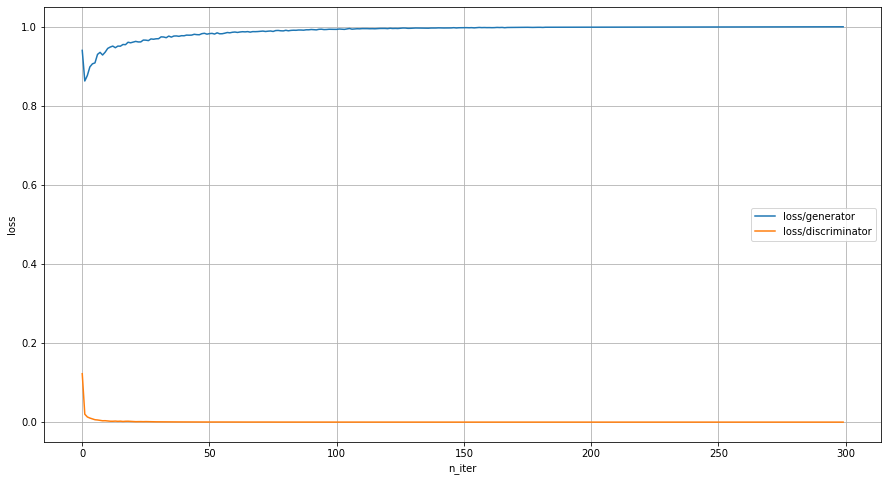

In [804]:
gd4 = do('LSGAN', n_iter)

In [843]:
gd = gd4

In [844]:
label_dict = { # c=0,g=1,t=2,a=3
    3: 'a',
    2: 't',
    1: 'g', 
    0: 'c'
}

print("".join([label_dict[nuc] for nuc in gd[-1]]))

tttcctttcatcttctagctatcctgtcccttgctccttttctgctttcttcccctccctgtaagaaacctgagagctccatccagaaaaaaagagaaagaaagatctgcaaaaaaaaaggtgtaaaagggtgtttcttttggtcaaggtgagggggagggcttgctaaagaatgtcagtttttcatgatctcccccttagctttatcatctaaagagttctaacctgggtgttagatccccctcctctctcccttttttttcccctcctcctccctttatcctgcctatctagaggggttcttcccctatgaggagctctccctttctgcctgcacgccagagatctctttacctttcaaaaaacgggagagctcaacgtgaaacctctctacttgtcctggcctggaaaaaaaaggtccgttatagagctctttcttttaaaacatcaagaaaggaaagcttttcttgatgtaaagctatctctttttaaagcataaa


In [845]:
gd[-BATCH_SIZE:].shape

(128, 500)

In [846]:
label_dict = { # c=0,g=1,t=2,a=3
    3: [0, 0, 0, 1],
    2: [0, 0, 1, 0],
    1: [0, 1, 0, 0], 
    0: [1, 0, 0, 0]
}

def int_to_nuc(sequence):
    #return np.asarray([label_dict[nuc] for nuc in sequence]).transpose(1,0)
    return np.asarray([label_dict[nuc] for nuc in sequence])#.transpose(1,0)


gd_new = np.stack([int_to_nuc(x) for x in gd[-BATCH_SIZE:]])

In [847]:
gd_new[1] # c транспоуз

array([[0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       ...,
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [848]:
gd_new.shape

(128, 500, 4)

# Валидация генератор на классификаторе

In [849]:
model = torch.load('model')

In [850]:
data_r = data_random[:gd_new.shape[0]]
data_new = np.concatenate((gd_new, data_r))
labels_fnl = np.concatenate((np.ones(len(gd_new)), np.zeros(len(data_r))))#, dtype=torch.float, device=cuda)

In [851]:
X_test = data_new
y_test = labels_fnl

In [852]:
from sklearn.metrics import roc_auc_score

data = torch.tensor(X_test, dtype=torch.float).transpose(1, 2)
model.eval()
with torch.no_grad():
    pred = model(data).numpy()
    
#print(roc_auc_score(y_test, pred))

0.87139892578125


In [853]:
y_pred = pred > 0.5

0.6430660409440251
0.8047619047619048
0.6796875


In [854]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[128,   0],
       [ 82,  46]], dtype=int64)

Text(0.5, 1.0, 'Confusion Matrix')

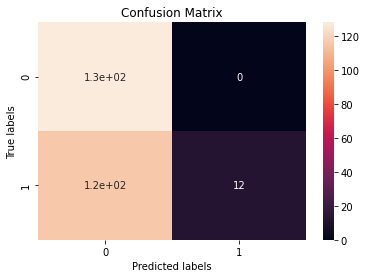

In [669]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')